# Setting

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc


2024-07-26 14:43:56.603395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 14:43:56.603537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 14:43:56.708036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np

# Specify the filename of saved .npz file
filename = "/kaggle/input/dfdc-training-data-gs/training_data_CLL.npz"

# Load the data from the .npz file using np.load
data = np.load(filename)

# Access the individual data arrays from the loaded data object
Video_train = data['Video_train']
Video_test = data['Video_test']
Audio_train = data['Audio_train']
Audio_test = data['Audio_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
max_sequence_video = 19 #max(len(video) for video in final_video_data)
max_sequence_audio = 25
video_shape = (max_sequence_video, 50 , 100, 1)
audio_shape = (max_sequence_audio , 128)


# Model Building

In [4]:
def CNN_LSTM_model(input_shape, drop_out):
    # Model Architecture
    video_input = Input(shape=input_shape)

    # CNN Layer
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(video_input)
    x = TimeDistributed(MaxPooling2D((4, 4)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(48, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)

    # LSTM layer
    x = LSTM(128, return_sequences=True)(x)
    video_features = LSTM(64)(x)

    # Create the model
    video_model = Model(inputs=video_input, outputs=video_features)

    return video_model

In [5]:
def LSTM_model(input_shape, drop_out):
    audio_input = Input(shape=input_shape)
    
    # Add Masking layer to handle variable-length sequences
    x = Masking(mask_value=0.0)(audio_input)
    
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(drop_out)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(drop_out)(x)
    x = LSTM(64, return_sequences=False)(x)
    
    # Create the model
    audio_model = Model(inputs=audio_input, outputs=x)

    return audio_model

In [6]:
def combined_model(video_input_shape, audio_input_shape, drop_out):
    # Create the video and audio models
    video_model = CNN_LSTM_model(video_input_shape, drop_out)
    audio_model = LSTM_model(audio_input_shape, drop_out)

    # Get the inputs and outputs
    video_feature = video_model.input
    audio_feature = audio_model.input
        
    # Apply cross-attention to the video and audio features    
    combined_features = Concatenate()([video_model.output, audio_model.output])
    
    # Fully connected layer
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(drop_out)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(drop_out)(x)
    x = Dense(32, activation='relu')(x)
    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Create the combined model
    model = Model(inputs=[video_feature, audio_feature], outputs=output)
    return model

In [7]:
model = combined_model(video_shape, audio_shape, 0.2)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19, 50,    │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 19, 50,    │        160 │ input_layer[0][0] │
│ (TimeDistributed)   │ 100, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 19, 12,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 25, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 19, 12,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 25, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 19, 12,    │      4,640 │ time_distributed… │
│ (TimeDistributed)   │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 19, 6, 12, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 19, 6, 12, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 19, 6, 12, │     13,872 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 19, 3, 6,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25, 128)   │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 19, 3, 6,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 25, 128)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 25)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 19, 3, 6,  │     27,712 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 25, 128)   │    131,584 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 19, 1, 3,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 501,041 (1.91 MB)

 Trainable params: 501,041 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

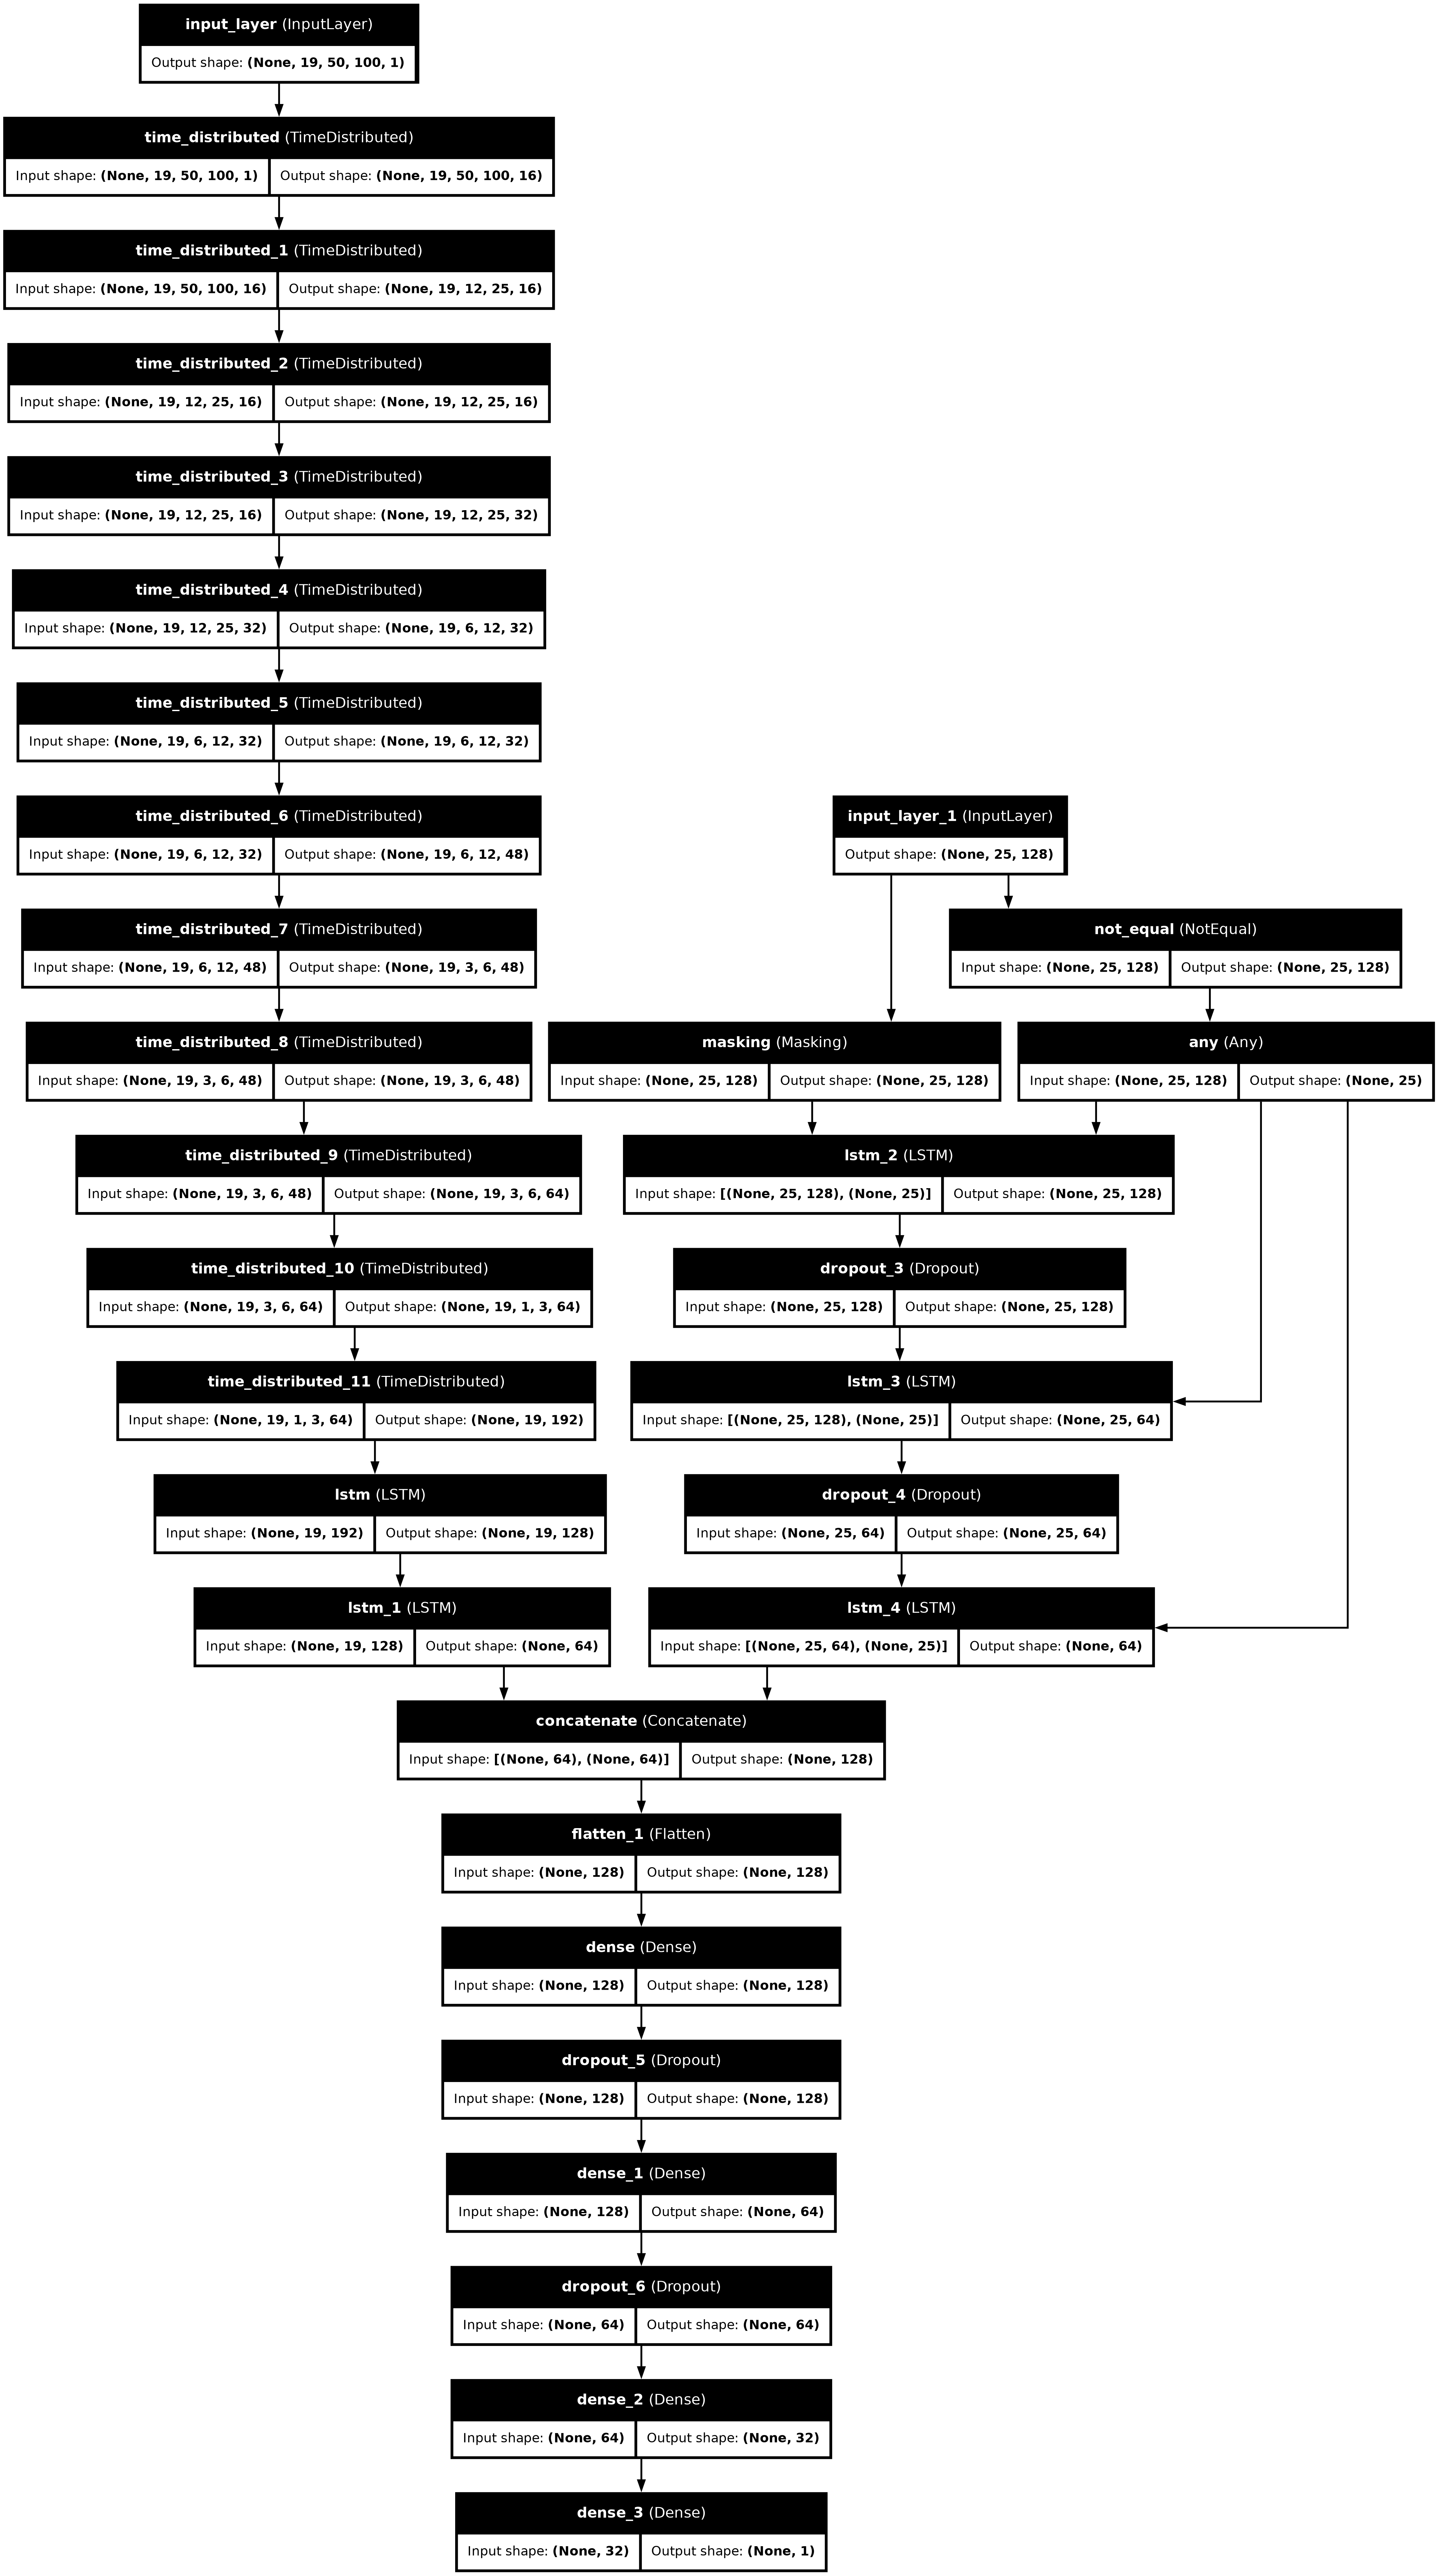

In [8]:
plot_model(model, show_shapes = True, show_layer_names = True)

## Model training

In [8]:
# Create Early Stopping Callback.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'binary_crossentropy', optimizer = "rmsprop" , metrics = ["accuracy"])
    
# Start training the model.
model_training = model.fit(x =[Video_train, Audio_train], y = y_train,
                                    epochs = 40, batch_size = 32 ,validation_data=([Video_test, Audio_test], y_test),
                                    shuffle = True,
                                    callbacks = [early_stopping])

Epoch 1/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 71s 138ms/step - accuracy: 0.5625 - loss: 0.6826 - val_accuracy: 0.6235 - val_loss: 0.6390
Epoch 2/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.6372 - loss: 0.6352 - val_accuracy: 0.6250 - val_loss: 0.6644
Epoch 3/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.6810 - loss: 0.5958 - val_accuracy: 0.6967 - val_loss: 0.6181
Epoch 4/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.7395 - loss: 0.5306 - val_accuracy: 0.7838 - val_loss: 0.4697
Epoch 5/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7616 - loss: 0.4922 - val_accuracy: 0.7995 - val_loss: 0.4414
Epoch 6/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7898 - loss: 0.4451 - val_accuracy: 0.8201 - val_loss: 0.3987
Epoch 7/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.8107 - loss: 0.4086 - val_accuracy: 0.8519 - val_loss: 0.3620
Epoch 8/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.8222 - loss: 0

## Plotting accuracy and loss

In [9]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

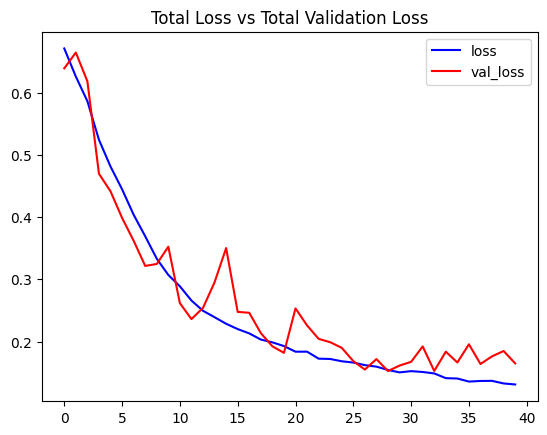

In [10]:
# Visualize the training and validation loss metrices.
plot_metric(model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

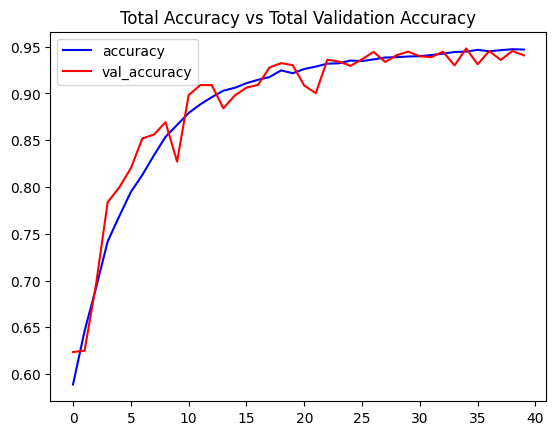

In [11]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Model Evaluation

In [12]:
# Evaluate the trained model.
model_evaluation = model.evaluate([Video_test, Audio_test], y_test)

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9460 - loss: 0.1497
